This notebook measures the intensities and errors of CO 2-1 emission at the locations of all of the SNe in our sample across all of the resolutions in the survey. This is used to prepare to answer the question in section 3.1 Do we see gas at supernova locations? 

We will use this to uncover what resolution will be best for this study.

In [1]:
# IMPORT PACKAGES

#global
import numpy as np
import bisect
from matplotlib import pyplot as plt
import astropy
import astropy.io.fits as pyfits
from astropy.table import Table, join
from astropy.wcs import WCS
from astropy.io import ascii
from astropy.io import fits
import os
from reproject import reproject_interp

#local
import sys
sys.path.append('/home/mayker.1/Desktop/PythonFunctions')

from findResolution import findRes
from getMapValue    import getValue
from nonZeroError   import findErrVals
from nonZeroError   import nonZeroErrArray
from nonZeroError   import findSignal
from nonZeroError   import findSignalArray
from findPercentiles import findStats

In [2]:
# DEFINE FUNCTIONS

def genFileName(galaxy, mapType, res, telOrient):
    
    """
    Generates the filenames for the CO maps.
    
    Parameters
    ----------
    galaxy    : string : name of galaxy
    mapType   : string : "int", "err", or "EW"   
    res       : string : resolution of map ("" (native), "_60pc", "_90pc", "_120pc", "_150pc", etc.)
    telOrient : string : 12m+7m+tp, 7m+tp, etc.
    
    Returns
    -------
    fileName : string : full path to file on Tycho.
        (/data/tycho/0/leroy.42/reduction/alma/phangs-alma/derived/ngc2997/ngc2997_12m+7m+tp_co21_150pc_broad_mom0.fits)

    """
    
    if mapType == "int":
        mapTypeStr = "_broad_mom0"
    elif mapType == "err":
        mapTypeStr = "_broad_emom0"
    elif mapType  == "EW":
        mapTypeStr = "_strict_ew"
    else:
        print("Wrong Map Type.")
        
    preamble = "/data/tycho/0/leroy.42/reduction/alma/phangs-alma/derived/" 
    
    fileName = preamble + galaxy + "/" + galaxy + "_" + telOrient + "_co21" + res + mapTypeStr + ".fits"
    return(fileName)


def getAlphaCO(acofileName, intfileName):
    """
    Pulls the metallicity dependent Alpha CO values using Sun+2020 maps
    or assigns a value of alpha CO = 4.35/0.65 if no Sun value is available.
    """

    if(os.path.isfile(acofileName) == True) and (os.path.isfile(intfileName) == True):
        hdu_int = pyfits.open(intfileName)
        hdu_aco = pyfits.open(acofileName)
        acoMap, footprint = reproject_interp(hdu_aco, hdu_int[0].header)

    else:
        #print("NO ACO file: ", acofileName)
        acoMap = 4.35/0.65
    
    return(acoMap)


In [3]:
# import SNeCO data

dataFile = '../Data/3.SNe+GalData.csv'
dataTable = Table.read(dataFile, format='csv') 
#dataTable.colnames

#import SNe data 
SNe_Gal_File = '../Data/3.SNe+GalData.csv'
SNe_Gal_Data = Table.read(SNe_Gal_File, format='csv') 

intenFile = '../Data/3.IntenData.csv'
intenData = Table.read(intenFile, format='csv')

database  = join(SNe_Gal_Data, intenData, keys=('SN_name', 'galaxy'))

In [4]:
# pull galaxy names and telescope orientation to generate the file lists

galaxies  = dataTable['galaxy']
telOrient = dataTable['telOrient']
SNname    = dataTable['SN_name']
SNra      = dataTable['SN_ra']
SNdec     = dataTable['SN_dec']
beamsize  = dataTable['map_beamsize']
telOrient = dataTable['telOrient']
distance  = dataTable['dist']
acoFile   = dataTable['AlphaCOFile']
incl      = dataTable['orient_incl']

In [5]:
# set up resolution array and galaxies without repeats
res = ['60', '90', '120', '150', '500', '750', '1k']
gals = list(dict.fromkeys(galaxies))
acos = list(dict.fromkeys(acoFile))
incls = list(dict.fromkeys(incl))
percentilesArr, fracs = [],[]

# find mgsd percentiles of all pixels from galaxy maps and weak. mod, strong percents of each resolution

for i in range(len(res)):
    weak, mod, strong = [],[],[]
    resSMPixArr, resSNRPixArr = [],[]

    resStr = "_" + res[i] +  "pc"

    for j in range(len(gals)):
        
        IntFileName = genFileName(gals[j], "int", resStr, telOrient[j])
        ErrFileName = genFileName(gals[j], "err", resStr, telOrient[j])
        
        if(os.path.isfile(IntFileName) == True and os.path.isfile(ErrFileName) == True):
                        
            hdulist = pyfits.open(IntFileName)
            map = hdulist[0].data
            flatmap=map.flatten()
            
            hdulistErr = pyfits.open(ErrFileName)
            mapErr = hdulistErr[0].data
            flatErrmap=mapErr.flatten()

            #remove nans
            keep  = np.where(np.isfinite(flatmap))
            galIntPixArr = flatmap[keep]
            galRawPixArr = flatmap[keep]
            galErrPixArr = flatErrmap[keep]
            
            lowErr = findErrVals(galErrPixArr)
            galErrPixArr = nonZeroErrArray(galErrPixArr, lowErr) 
            galIntPixArr = np.clip(galIntPixArr, 0, np.max(galIntPixArr))
            galSNRPixArr = findSignalArray(galIntPixArr, galErrPixArr)

            # get alphaco information
            acoMap = getAlphaCO(acos[j], IntFileName)

            if isinstance(acoMap, float) == False:
                acoMap = acoMap.flatten()
                acoMap = acoMap[keep]
            
            galSMPixArr = galRawPixArr * acoMap * np.cos(incls[j]* np.pi/180)
            
            #add to full list
            resSMPixArr = np.concatenate((galSMPixArr, resSMPixArr), axis=0)
            resSNRPixArr = np.concatenate((galSNRPixArr, resSNRPixArr), axis=0)
            #print("file for ", gals[j], " at resolution ", res[i])
            
        else:
            pass
            #print("No file for ", galaxies[j], " at resolution ", res[i])
                
    resArr = np.sort(resSMPixArr)
    resCS = np.cumsum(resArr)/np.sum(resArr)
    perArr = np.interp([0.16, 0.5, 0.84],resCS,resArr)
    for k in range(len(perArr)):
        perArr[k] = round(perArr[k],2)
    print("Resolution: ", res[i], " Percentiles: ", perArr)
    percentilesArr.append(perArr)
    sortedRes = np.sort(resSNRPixArr)
    idx3 = bisect.bisect_left(sortedRes,3)
    idx7 = bisect.bisect_left(sortedRes,7)
    numPix = len(sortedRes)
    fracWeak = float(idx3)/numPix
    fracMod = float(idx7-idx3)/numPix
    fracStrong = float(numPix-idx7)/numPix
    frac = [fracWeak, fracMod, fracStrong]
    fracs.append(frac)
print(percentilesArr)
print(fracs)
    
    
#write a return statement here to save these values for future plot
# save the fraction of strong, mod, weak measurements

Resolution:  60  Percentiles:  [ 17.09  46.89 201.26]
Resolution:  90  Percentiles:  [ 14.12  42.72 194.38]
Resolution:  120  Percentiles:  [ 13.78  47.9  297.08]
Resolution:  150  Percentiles:  [ 12.97  45.78 274.2 ]
Resolution:  500  Percentiles:  [ 10.01  32.   169.96]
Resolution:  750  Percentiles:  [  9.89  28.96 142.56]
Resolution:  1k  Percentiles:  [  9.93  27.21 120.93]
[array([ 17.09,  46.89, 201.26]), array([ 14.12,  42.72, 194.38]), array([ 13.78,  47.9 , 297.08]), array([ 12.97,  45.78, 274.2 ]), array([ 10.01,  32.  , 169.96]), array([  9.89,  28.96, 142.56]), array([  9.93,  27.21, 120.93])]
[[0.7225745935322494, 0.16582436155313618, 0.1116010449146144], [0.709862625761676, 0.16617325695966084, 0.12396411727866319], [0.7030797656198061, 0.16483370368654218, 0.13208653069365175], [0.650282301428791, 0.18230903753517524, 0.16740866103603386], [0.33570131204953363, 0.19528065871809588, 0.46901802923237046], [0.2300366615297458, 0.15399188823943524, 0.6159714502308189], [0.1

In [6]:
print("All Pixel Stats")
print("Res  Weak   Mod     Strong")
for i in range(len(res)):
    print(res[i], fracs[i])

All Pixel Stats
Res  Weak   Mod     Strong
60 [0.7225745935322494, 0.16582436155313618, 0.1116010449146144]
90 [0.709862625761676, 0.16617325695966084, 0.12396411727866319]
120 [0.7030797656198061, 0.16483370368654218, 0.13208653069365175]
150 [0.650282301428791, 0.18230903753517524, 0.16740866103603386]
500 [0.33570131204953363, 0.19528065871809588, 0.46901802923237046]
750 [0.2300366615297458, 0.15399188823943524, 0.6159714502308189]
1k [0.17725459314299602, 0.11364070378138234, 0.7091047030756217]


In [12]:

# def percentiles(array):

#     vals = np.asarray(array)
    
# #     for i in range(len(vals)):
# #         if vals[i] < 0.0:
# #             vals[i] = 0.0
    
#     vals = vals[np.isfinite(vals)]
    
#     percentile = np.linspace(0,1,len(vals))
#     stats = findStats(percentile, vals)

#     return(stats, len(vals))

def mgsdPercentiles(res):

    msgdStr = "pc" + str(res) + "mgsd"
    errStr = "pc" + str(res) + "mgsdErr"

    mgsdgroup = database.group_by([msgdStr, errStr])

    mgsdNotNan = []
    
    # remove nans and set negative values to zero
    for i in range(len(mgsdgroup)):
        if np.isfinite(mgsdgroup[msgdStr][i]):
            mgsdNotNan.append(mgsdgroup[msgdStr][i])

    # find normalized cumulative dictribution    
    mgsdSort = np.sort(mgsdNotNan)
    
    mgsdCS = np.cumsum(mgsdSort)/np.sum(mgsdSort)
    perArr = np.interp([0.16, 0.5, 0.84],mgsdCS,mgsdSort)
    for k in range(len(perArr)):
        perArr[k] = round(perArr[k],2)
    print("Resolution: ", res, " Percentiles: ", perArr)
    percentilesArr.append(perArr)
    
    return(percentilesArr)


In [15]:
# Find entries for Latex Table : MGSD Percentiles at all resolutions at locations of SNe

pc60mgsdTiles = mgsdPercentiles(60)
pc90mgsdTiles = mgsdPercentiles(90)
pc120mgsdTiles = mgsdPercentiles(120)
pc150mgsdTiles = mgsdPercentiles(150)
pc500mgsdTiles = mgsdPercentiles(500)
pc750mgsdTiles = mgsdPercentiles(750)
pc1000mgsdTiles = mgsdPercentiles(1000)

SNtiles = [pc60mgsdTiles,pc90mgsdTiles,pc120mgsdTiles,pc150mgsdTiles,pc500mgsdTiles,pc750mgsdTiles,pc1000mgsdTiles]

60 7 [128.56 324.77 548.54]
90 19 [ 87.94 293.84 583.09]
120 47 [ 70.3  325.93 789.23]
150 59 [ 76.21 317.94 740.26]
500 62 [ 60.96 216.03 645.07]
750 63 [ 57.95 209.31 545.31]
1000 63 [ 46.17 164.36 474.16]


<ipython-input-9-4990b220f976>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["", "60 pc", "90 pc", "120 pc", "150 pc", "500 pc", "750 pc", "1 kpc"], fontsize=14)


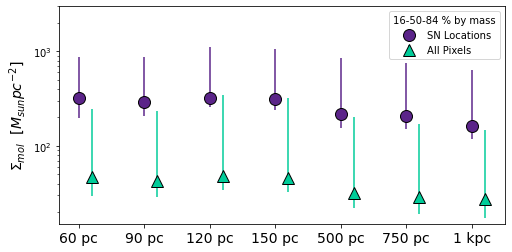

In [9]:
darkpurple = '#5B2489'
tealgreen  = "#00cc99"

xSN, ySN, errLowSN, errHighSN = [],[],[],[]
xAP, yAP, errLowAP, errHighAP = [],[],[],[]

for i in range(len(SNtiles)):
    errLowSN.append(SNtiles[i][0])
    ySN.append(SNtiles[i][1])
    errHighSN.append(SNtiles[i][2])
    xSN.append(i)
    errLowAP.append(percentilesArr[i][0])
    yAP.append(percentilesArr[i][1])
    errHighAP.append(percentilesArr[i][2])
    xAP.append(i+0.2)

# plot MGSD table using SNtiles and percentilesArr
f, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (8,4))
ax.set_yscale('log')
ax.errorbar(xSN, ySN, yerr=np.vstack([errLowSN, errHighSN]), ls="", marker="o",label="SN Locations",color = darkpurple,mec='black', ms = 12)
ax.errorbar(xAP, yAP, yerr=np.vstack([errLowAP, errHighAP]), ls="", marker="^", label="All Pixels",color = tealgreen,mec='black', ms = 12)
ax.legend(loc="best", title = "16-50-84 % by mass")
ax.set_ylabel(r"$\Sigma_{mol}$  $[M_{sun}pc^{-2}]$", fontsize = 14)
ax.set_xticklabels(["", "60 pc", "90 pc", "120 pc", "150 pc", "500 pc", "750 pc", "1 kpc"], fontsize=14)
ax.set_ylim(15, 3000)
plt.savefig("../Figures/MGSDbyResolution.png",dpi=300)
plt.show()
plt.close()